In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.patches as mpatches
import numpy as np
import math

import mahotas as mh
import cv2
from PIL import Image

import copy

from skimage import io
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, opening, square, disk
from skimage.color import label2rgb, rgb2gray

from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

from skimage.filters import threshold_local, threshold_adaptive, threshold_otsu
from skimage.filters import sobel

path_orig = "/media/ula/D/mikroskop/CA1/MAX_CA1_glass_28_rat_1_hipp_left_skan_2019-08-05_flat.tif"

path_comm = "/media/ula/D/2p_fosgfp2020/tst.tif"

dapi_path = path_comm #+ "1.tif"
homer_path = path_comm + "2.tif"
arc_path = path_comm + "3.tif"

In [2]:
def get_frac_thresh(arr, frac):
    min_lum = np.min(arr)
    max_lum = np.max(arr)
    return min_lum + frac*(max_lum - min_lum)

In [3]:
class Nucleus(): 
    def __init__(self, nucelusProps, approxEllipse,  idno):
        self.nucelusProps = nucelusProps
        self.approxEllipse = approxEllipse
        self.idno = idno
   

In [4]:
def ieg_segmentation(image_ts, footprint_size, thresh_down, thresh_up, thresh_range, sobel_g=False): 
    T_mean = image_ts.mean()
    opened = opening(image_ts > T_mean/4, square(3))
    bw = closing(opened, square(3))

    thre = get_frac_thresh(image_ts, 0.10)
    binary_local = image_ts > thre
    
    local_masked_global = np.ma.masked_array(data = binary_local, mask = ~bw, fill_value = 0).filled()

    elev_map = sobel(mh.gaussian_filter(image_ts,2))
    distance = ndi.distance_transform_edt(local_masked_global)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
                                labels=local_masked_global)
    markers = ndi.label(local_maxi)[0]

   
    labels = watershed(-elev_map, markers, mask=local_masked_global)

    label_image = label(labels, connectivity = 1)
    

    fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(label_image)
    ax[0].set_title("Labelled")
    
    ax[1].imshow(image_ts)
    ax[1].set_title("orig img")

    areas = np.array([])
    regions_to_reconsider = []

    for region in regionprops(label_image):
        areas = np.append(areas, region.area)

   
    nuclei = np.array([])

    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Circle((region.centroid[1], region.centroid[0]), region.major_axis_length, 
                               fill=False, edgecolor='red', linewidth=2)
        if region.area >= thresh_up:
            ax[0].add_patch(rect)
            regions_to_reconsider = np.append(regions_to_reconsider, region)
        elif region.area >= thresh_down:
            nuclei = np.append(nuclei, region)    
            ax[0].add_patch(rect)

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
    return nuclei, regions_to_reconsider, label_image

In [12]:
def dapi_segmentation(image_ts, footprint_size, thresh_down, thresh_up, thresh_range, sobel_g=False): 
    image_ts_orig = copy.copy(image_ts)
    
    image_ts = opening(image_ts, disk(2))
    
    thresh = threshold_otsu(image_ts)/3
    #closed = closing(image_ts > T_mean, disk(11))
    

    local_thresh = threshold_local(image_ts, thresh_range, offset=0)
    binary_local = image_ts > local_thresh

    
    local_masked_global = np.ma.masked_array(data = binary_local, 
                                             mask = ~(image_ts > thresh), fill_value = 0).filled()
    #local_masked_global = closing(local_masked_global, disk(3))
    #local_masked_global = opening(local_masked_global, disk(2))
    
    elev_map = sobel(mh.gaussian_filter(image_ts,3))
    distance = ndi.distance_transform_edt(local_masked_global)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((footprint_size,footprint_size)),
                                labels=local_masked_global)
    markers = ndi.label(local_maxi)[0]
   
    labels = watershed(-elev_map, markers, mask=local_masked_global)

    label_image = label(labels, connectivity = 1)
    

    fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)
    ax = axes.ravel()

    #ax[0].imshow(label_image)
    #ax[0].set_title("Labelled")
    ax[0].imshow(image_ts_orig)
    ax[0].set_title("Labelled")
    
    ax[1].imshow(image_ts)
    ax[1].set_title("orig img")
    

    im = Image.fromarray(image_ts)
    im.save("/home/ula/ppp/catfish/image_ts.tif")
    
    areas = np.array([])
    regions_to_reconsider = []

    for region in regionprops(label_image):
        areas = np.append(areas, region.area)

    std = np.std(areas)
    mean = np.mean(areas)


    nuclei = np.array([])
    
    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        
        approxEllipse = mpatches.Ellipse((region.centroid[1],region.centroid[0]), region.minor_axis_length,
                                                         region.major_axis_length,90-(180/math.pi)*region.orientation,
                       fill=False, edgecolor='red', linewidth=1)
        if region.area >= thresh_up:
            ax[0].add_patch(approxEllipse)
            regions_to_reconsider = np.append(regions_to_reconsider, region)
        elif region.area >= thresh_down:
            new_nucleus = Nucleus(region, copy.copy(approxEllipse), len(nuclei))
            nuclei = np.append(nuclei, new_nucleus)      
            ax[0].add_patch(approxEllipse)
    
    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
    return nuclei, regions_to_reconsider, label_image

255
93 76


<IPython.core.display.Javascript object>


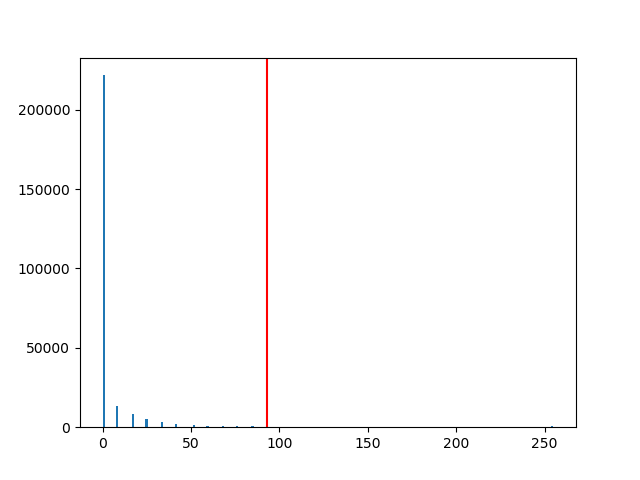

In [11]:
image = io.imread(dapi_path)
print(np.max(image))
plt.ioff()
print(threshold_otsu(image[image>0]), threshold_otsu(image))
plt.axvline(threshold_otsu(image[image>0]), color='red')
hist = plt.hist(image.flatten(), 200)
plt.show()

/home/ula/anaconda3/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/ula/anaconda3/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


<IPython.core.display.Javascript object>


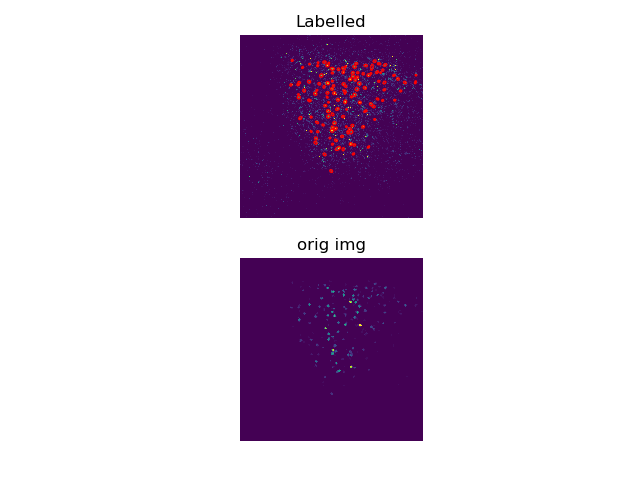

125 0


'\narc_im = io.imread(arc_path)\nhomer_im = io.imread(homer_path)\n\narc_locations, _,_ = ieg_segmentation(arc_im, 2, 7, 30, 21)\nhomer_locations, _,_ = ieg_segmentation(homer_im, 2, 7, 30, 21)\n'

In [13]:
nuclei, regions_to_reconsider, thresholded = dapi_segmentation(image, 4, 10, 1250, 39)#, sobel_g = True)
print(len(nuclei), len(regions_to_reconsider))
'''
arc_im = io.imread(arc_path)
homer_im = io.imread(homer_path)

arc_locations, _,_ = ieg_segmentation(arc_im, 2, 7, 30, 21)
homer_locations, _,_ = ieg_segmentation(homer_im, 2, 7, 30, 21)
'''

In [8]:
def prepare_coords_set(coords_tab):
    return set(tuple([m, n]) for m, n in zip(coords_tab[:,0], coords_tab[:,1]))

def find_ieg_colloc(ieg_locs, nuclei, to_reevaluate):
    ieg_positive = np.array([])
    fig, ax = plt.subplots(figsize=(6, 6))
    full_image = io.imread(path_orig)
    ax.imshow(full_image)
    for nucleus in nuclei:
        nucleus_patch = copy.copy(nucleus.approxEllipse)
        ieg_no = 0
        for ieg_dot in ieg_locs:
            ieg_centroid = ieg_dot.centroid      
            #if the centroid of area identified as immediate early gene presence is inside of nucleus, add it
            #to the number of ieg collocalized with the nucleus
            
            tmp = nucleus.approxEllipse.contains_point((ieg_centroid[1], ieg_centroid[0]))
            
            if (tmp):
                ieg_no +=1
                if ieg_no == 1:
                    ieg_positive = np.append(ieg_positive, nucleus.idno)
                     
                    minr, minc, maxr, maxc = ieg_dot.bbox
                    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                                      fill=False, edgecolor='red', linewidth=1)
                
                    nucleus_patch.set_color('white')
                    #ax.add_patch(rect)   
        if ieg_no > 1:
            to_reevaluate = np.append(to_reevaluate, nucleus)
        ax.add_patch(nucleus_patch)   
    ax.set_axis_off()

    fig.tight_layout()
    plt.title("colloc")
    plt.show()
    return ieg_positive, to_reevaluate

In [9]:
to_reevalueate = []

arc_pos, arc_mult =  find_ieg_colloc(arc_locations, nuclei, to_reevalueate)
homer_pos, homer_mult =  find_ieg_colloc(homer_locations, nuclei, to_reevalueate)

print('arc len ', len(arc_pos), len(arc_mult))
print('homer len ', len(homer_pos),len(homer_mult))


NameError: name 'arc_locations' is not defined

In [ ]:
print(arc_pos)
print(homer_pos)

In [ ]:
len(np.intersect1d(arc_pos, homer_pos))

In [ ]:
help(cv2.watershed)

In [ ]:
def dapi_segmentation2(image_ts):
    img = cv2.imread(image_ts)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)

    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 5)

    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
    ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    markers = cv2.watershed(img,markers)
    img[markers == -1] = [255,0,0]
    
    fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(dist_transform)
    ax[0].set_title("res")
    
    ax[1].imshow(img)
    ax[1].set_title("orig")
    
    plt.show()
    
dapi_segmentation2(dapi_path)

In [ ]:
full_color_path = "/media/ula/D/mikroskop/CA1/MAX_CA1_glass_28_rat_1_hipp_left_skan_2019-08-05.tif"

full_color_im = io.imread(full_color_path)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(full_color_im)
ax.set_axis_off()

fig.tight_layout()
plt.show()

In [ ]:
nuclei[0].nucelusProps.centroid

In [ ]:
nuclei[0].nucelusProps.centroid[::-1]